In [4]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
%matplotlib inline
import matplotlib.dates as mdates
from time import strptime

In [5]:
RawData = pd.read_csv('Broadfields10minMet.dat',na_values='-')
RawData.dropna(axis=1,how='all',inplace=True)

In [6]:
RawData.loc[:,'Date'] = [datetime.datetime(RawData.loc[x,'Year'],
                 strptime(RawData.loc[x,'Month'],'%b').tm_mon,
                 RawData.loc[x,'Day'],
                 RawData.loc[x,'Hour'],
                 RawData.loc[x,'Min'],) for x in RawData.index]

In [7]:
RawData.set_index('Date',inplace=True)

In [8]:
RawData.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Min','MnDir(degT)', 
                      'GstDir(degT)','GstSpd(mps)','StdDir(degT)', 'StdSpd(mps)', 'Pmsl(hPa)'],inplace=True)

In [9]:
RawData.columns

Index(['MnSpd(mps)', 'MnTemp(C)', 'MnRH(%)', 'Rain(mm)', 'RadGlb(MJ/m2)'], dtype='object')

In [10]:
RawData.columns = ['Windspeed','AirTemperature','RelativeHumidity','Rainfall','IncomingRadnMJ']

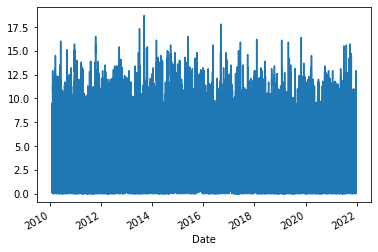

In [11]:
RawData.loc[:,'Windspeed'].plot()

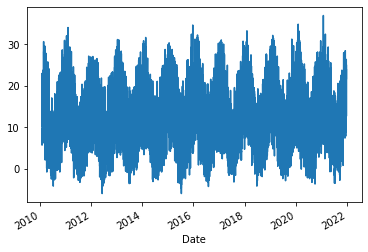

In [12]:
RawData.loc[:,'AirTemperature'].plot()

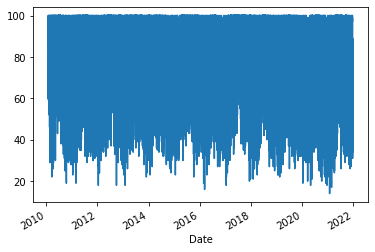

In [13]:
RawData.loc[:,'RelativeHumidity'].plot()

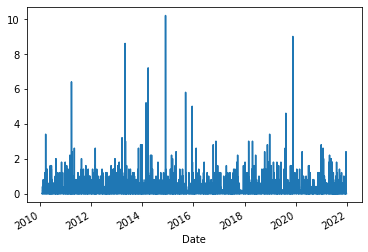

In [14]:
RawData.loc[:,'Rainfall'].plot()

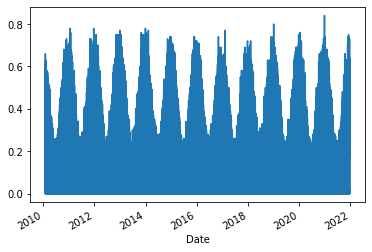

In [15]:
RawData.loc[:,'IncomingRadnMJ'].plot()

In [16]:
RawData.to_pickle('BroadFieldsMet.pkl')

In [17]:
for x in RawData.index:
    RawData.loc[x,'vp'] = et.vp(RawData.loc[x,'AirTemperature'], RawData.loc[x,'RelativeHumidity'])

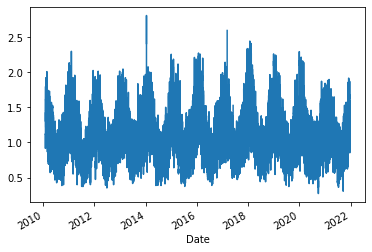

In [18]:
RawData.loc[:,'vp'].plot()

In [19]:
Radn = RawData.loc[:,'IncomingRadnMJ'].resample('D').sum()
Temp = RawData.loc[:,'AirTemperature'].resample('D').mean()
Wind = RawData.loc[:,'Windspeed'].resample('D').mean()
Hum = RawData.loc[:,'RelativeHumidity'].resample('D').mean()
vp = RawData.loc[:,'vp'].resample('D').mean()
PET = pd.DataFrame(index = Radn.index, columns = ['PET'],
                   data = [et.PenmanEO(Radn[x],
                            Temp[x],
                            Wind[x],
                            vp[x],
                            "total") for x in Radn.index])

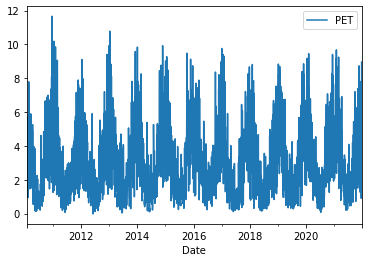

In [20]:
PET.plot()

## Bring in MeanData and use to plug gaps

In [21]:
MeanPET = pd.read_pickle('C:/GitHubRepos/2020/Weather/MeanPET.pkl')

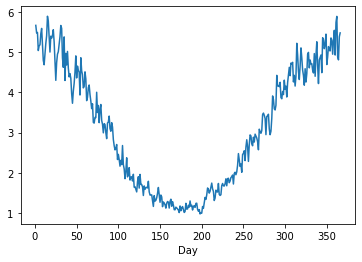

In [22]:
MeanPET.plot()

In [23]:
import math
for x in PET.index:
    if math.isnan(PET.PET[x]) == True:
        PET.PET[x] = MeanPET[x.dayofyear]

In [24]:
PET.to_pickle('BroadFieldsPET.pkl')

In [25]:
RawData.loc[:,'VPD'] = [et.vapor_pressure_deficit(RawData.loc[x,'AirTemperature'],
                           et.vp(RawData.loc[x,'AirTemperature'],
                                RawData.loc[x,'RelativeHumidity'])*10) for x in RawData.index]

In [26]:
DaylightFilter = RawData.loc[:,'IncomingRadnMJ'] > 0.001

In [27]:
VPD = RawData.loc[DaylightFilter,'VPD'].resample('D').mean()

In [28]:
VPD.index.month.isin([1,2,12])

array([ True,  True,  True, ...,  True,  True,  True])

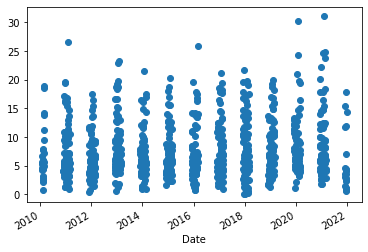

In [29]:
VPD.loc[VPD.index.month.isin([1,2,12])].plot(style='o')